In [1]:
%load_ext autoreload
%autoreload 2
from numpy import sin, cos, pi, array
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.animation as animation
import math


metadata = dict(title='Quad 2D', artist='Pete Florence',
        comment='Rotate time')
writer = animation.AVConvWriter(fps=20, metadata=metadata, bitrate=5000)


# constant velocity
v = 8

def derivs(state, t):

    dqdt = np.zeros_like(state)
    
    dqdt[0] = -v*sin(state[2])
    dqdt[1] = -v*cos(state[2]) 
    dqdt[2] = 0 #sin(2*t)
    
    return dqdt

# create a time array from 0...30 sampled at 0.05 second steps
dt = 0.05
t = np.arange(0.0, 4, dt)

# initial positions
# x and y are position of origin.  We move the origin, not the plane, so that the plane stays in the same spot in the plot.
# psi is yaw, and psidot is yawdot of plane
x = 0.0
y = 0.0
psi = 0.0

rad = pi/180.0

# initial state
state = np.array([x, y, psi*rad])

print "integrating..."
# integrate your ODE using scipy.integrate.
y = integrate.odeint(derivs, state, t)
print "done"

xworld = y[:,0]
yworld = y[:,1]
psiworld = y[:,2]

def rotateWorldIntoPlaneFrame(xworld,yworld,psiworld):
    Rtraj = np.sqrt(xworld**2 + yworld**2)
    thetatraj = np.arctan2(xworld, yworld)
    thetatraj = thetatraj - psiworld
    xtraj = Rtraj*np.sin(thetatraj)
    ytraj = Rtraj*np.cos(thetatraj)
    return xtraj, ytraj

xworld, yworld = rotateWorldIntoPlaneFrame(xworld,yworld,psiworld)
    
from ObstacleField import ObstacleField
from Obstacle import Obstacle

#Custom test field
# obsField = ObstacleField()
# obsField.addObstacle(Obstacle(3,4))
# obsField.addObstacle(Obstacle(-2,7))
# obsField.addObstacle(Obstacle(13,14))
# obsField.addObstacle(Obstacle(-12,17))
# obsField.addObstacle(Obstacle(23,24))
# obsField.addObstacle(Obstacle(-22,27))
# obsField.addObstacle(Obstacle(33,34))
# obsField.addObstacle(Obstacle(-12,37))
# obsField.addObstacle(Obstacle(13,44))
# obsField.addObstacle(Obstacle(-12,57))
# obsField.addObstacle(Obstacle(3,54))
# obsField.addObstacle(Obstacle(-2,53))

# # Random field
obsField = ObstacleField()
obsField.randomField(M=50)
for i in obsField.ObstaclesList:
    i.computeTraj(psiworld,xworld,yworld)

integrating...
done


precomputing laser data...
done


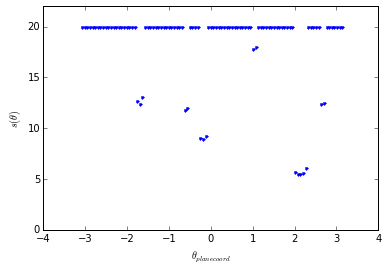

In [2]:
# Add laser
from libLaserDepths import computeLaserDepthsTraj
from LineCircleIntersect import intersect
laserLines = []
approxLines = []
D = 100 # Number of discrete data points from laser
laseAngles = np.linspace(-math.pi,math.pi,D+1)[0:D]

#S_max
S_maxdist = 20
S_max_t = np.linspace(-math.pi,math.pi,100)
S_max_x = S_maxdist*np.cos(S_max_t)
S_max_y = S_maxdist*np.sin(S_max_t)

xlist = []
ylist = []

print "precomputing laser data..."
laserDepthsTraj, x_laser_endpointTraj, y_laser_endpointTraj = computeLaserDepthsTraj(xworld, yworld, laseAngles, S_maxdist, obsField)
print "done"


%matplotlib inline
from coordTransforms import transformStandardPolarTheta_to_PlaneTheta
laseAngles2 = laseAngles * 0
for i in range(len(laseAngles)):
    laseAngles2[i] = transformStandardPolarTheta_to_PlaneTheta(laseAngles[i])
    
    
plt.plot(laseAngles2,laserDepthsTraj[0,:],'.')
plt.xlabel(r'$\theta_{plane coord}$')
plt.ylabel(r'$s(\theta)$')
plt.axis([-4, 4, 0, 22])
plt.show()

# import csv
# with open('laserdata.csv', 'wb') as csvfile:
#     laserwriter = csv.writer(csvfile, delimiter=',',
#                             quotechar='|', quoting=csv.QUOTE_MINIMAL)
#     for i in range(len(laserDepths)):
#         laserwriter.writerow([laseAngles2[i], laserDepths[i]])


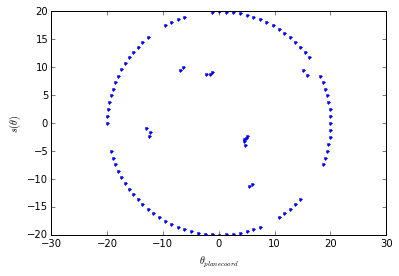

In [3]:
# Plot in x,y
laseX = laseAngles*0.0
laseY = laseAngles*0.0

for i in range(len(laseX)):
    laseX[i] = laserDepthsTraj[0,i] * cos(laseAngles[i])
    laseY[i] = laserDepthsTraj[0,i] * sin(laseAngles[i])
    

plt.plot(laseX,laseY,'.')
plt.xlabel(r'$\theta_{plane coord}$')
plt.ylabel(r'$s(\theta)$')
plt.axis('equal')
plt.show()



In [4]:
# # Add limitation for edges
# laserDepthsTraj[:,0] = 0.1
# laserDepthsTraj[:,-1] = 0.1

# plt.plot(laseAngles2,laserDepthsTraj[0,:],'.')
# plt.xlabel(r'$\theta_{plane coord}$')
# plt.ylabel(r'$s(\theta)$')
# plt.axis([-4, 4, 0, 22])
# plt.show()

In [5]:

import scipy.optimize as opt
from linear_regression import LinearRegression

N = 11
laserDepths = laserDepthsTraj[0,:]
lr = LinearRegression(laseAngles2,laserDepths,N)

def horner(x, weights):
    coefficients = weights[::-1]
    result = 0
    for i in coefficients:
        result = result * x + i
    return result

In [6]:
# Define matrices that then I will need

def setUpQP():
    
    A_pete = np.zeros((len(laseX),11))
    for index, row in enumerate(A_pete):
        x=laseX[index]
        y=laseY[index]
        row[0] = 1
        row[1] = x
        row[2] = y
        row[3] = x*y
        row[4] = x**2
        row[5] = y**2
        row[6] = x**2*y
        row[7] = x*y**2
        row[8] = x**2 * y**2
        row[9] = x**3
        row[10] = y**3
            
    #W = weighting matrix
    weights = laserDepths * 1.0
    for index, value in enumerate(weights):
        #weights[index] = (1/value)**4
        weights[index] = 1
    W_pete = np.diag(weights)
    
    #b = vector of sensor measurements
    b_pete = laserDepths
    
    return np.matrix(A_pete), np.matrix(W_pete), np.matrix(b_pete)
    
A_pete, W_pete, b_pete = setUpQP()

print np.shape(A_pete)
print np.shape(A_pete.T)
print np.shape(A_pete * A_pete.T)
print np.shape(A_pete.T * A_pete)

(100, 11)
(11, 100)
(100, 100)
(11, 11)


In [7]:
import cvxopt

# P = A^T W A
P = cvxopt.matrix(A_pete.T * W_pete * A_pete)

# q^T = -b^T A
# q = -A^T b
q = cvxopt.matrix(- A_pete.T * W_pete *b_pete.T)

# G = A
A_pete_add = np.zeros((1,11))
A_pete_add[0,0] = 1
A_pete_ineq = np.vstack((A_pete, A_pete_add))
G = cvxopt.matrix(A_pete_ineq)

# h = b_pete
print np.shape(b_pete)
b_add = np.ones((1,1))
b_pete_ineq = np.hstack((b_pete, b_add))
h = cvxopt.matrix(b_pete_ineq.T)

A_zeros = np.copy(A_pete)
A_zeros[::] = 0

b_zeros = np.copy(b_pete)
b_zeros[:] = 0

A = cvxopt.matrix(A_zeros)
b = cvxopt.matrix(b_zeros.T)

# find the solution 
solution = cvxopt.solvers.qp(P, q, G, h)

alpha = np.array(solution['x'])

print alpha


(1, 100)
     pcost       dcost       gap    pres   dres
 0: -1.7657e+04 -1.7619e+04  2e+03  3e-01  1e-01
 1: -1.7380e+04 -1.7739e+04  4e+02  1e-16  8e-17
 2: -1.7527e+04 -1.7574e+04  5e+01  2e-16  6e-17
 3: -1.7550e+04 -1.7556e+04  6e+00  2e-16  9e-18
 4: -1.7553e+04 -1.7554e+04  1e+00  2e-16  1e-16
 5: -1.7554e+04 -1.7554e+04  2e-01  2e-16  1e-16
 6: -1.7554e+04 -1.7554e+04  3e-02  2e-16  9e-17
 7: -1.7554e+04 -1.7554e+04  2e-03  2e-16  1e-16
Optimal solution found.
[[  9.99999594e-01]
 [ -7.41953951e-02]
 [  6.78791454e-02]
 [ -2.08091600e-06]
 [  4.74997641e-02]
 [  4.74996683e-02]
 [ -1.69634017e-04]
 [  1.85594346e-04]
 [ -1.64044933e-08]
 [  1.85495488e-04]
 [ -1.69683183e-04]]


In [8]:
import plotly
import plotly.plotly as py
import plotly.tools as tls
from plotly.graph_objs import *
from numpy import pi, cos, exp


def fxy(x, y):
    A = 1  # choose a maximum amplitude 
    return alpha[0] + alpha[1]*x + alpha[2]*y + alpha[3]*x*y + alpha[4]*x**2 + alpha[5]*y**2 + alpha[6]*x**2*y + alpha[7]*x*y**2 + alpha[8]*x**2*y**2 + alpha[9]*x**3 + alpha[10]*y**3

L = 40
x = y = np.arange(-L/2., L/2., 0.1)  # use a mesh spacing of 0.1
yt = y[:, np.newaxis]  # (!) make column vector

# Get surface coordinates!
z = fxy(x, yt)

trace1 = Surface(
    z=z,  # link the fxy 2d numpy array
    x=x,  # link 1d numpy array of x coords
    y=y   # link 1d numpy array of y coords
)

# Package the trace dictionary into a data object
data = Data([trace1])

# Dictionary of style options for all axes
axis = dict(
    showbackground=True, # (!) show axis background
    backgroundcolor="rgb(204, 204, 204)", # set background color to grey
    gridcolor="rgb(255, 255, 255)",       # set grid line color
    zerolinecolor="rgb(255, 255, 255)",   # set zero grid line color
)

# Make a layout object
layout = Layout(
    title='$f(x,y) = \sum_{i,j} a _{i,j} x^{i}y^{j} $', # set plot title
    scene=Scene(  # (!) axes are part of a 'scene' in 3d plots
        xaxis=XAxis(axis), # set x-axis style
        yaxis=YAxis(axis), # set y-axis style
        zaxis=ZAxis(axis)  # set z-axis style
    )
)

# Make a figure object
fig = Figure(data=data, layout=layout)

# (@) Send to Plotly and show in notebook
py.iplot(fig, filename='s8_surface')

In [9]:
# LP

from cvxopt import matrix, solvers
c = np.zeros((N,1))

for i in range(D):
    c[0]  -= 1
    c[1]  -= laseX[i]
    c[2]  -= laseY[i]
    c[3]  -= laseX[i] * laseY[i]
    c[4]  -= laseX[i]**2
    c[5]  -= laseY[i]**2
    c[6]  -= laseX[i]**2 * laseY[i]
    c[7]  -= laseX[i] * laseY[i]**2
    c[8]  -= laseX[i]**2 * laseY[i]**2
    c[9]  -= laseX[i]**3
    c[10] -= laseY[i]**3
    
c = cvxopt.matrix(c)
print np.shape(c)

print np.shape(G)
print np.shape(h)

sol = solvers.lp(c, G, h)
alpha = sol['x']

(11, 1)
(101, 11)
(101, 1)
     pcost       dcost       gap    pres   dres   k/t
 0: -1.8337e+03 -1.8337e+03  5e+02  3e-01  4e-16  1e+00
 1: -1.7881e+03 -1.7864e+03  2e+02  1e-01  1e-16  2e+00
 2: -1.7835e+03 -1.7833e+03  2e+01  1e-02  1e-16  2e-01
 3: -1.7828e+03 -1.7827e+03  5e+00  3e-03  3e-16  5e-02
 4: -1.7825e+03 -1.7825e+03  2e+00  1e-03  6e-16  2e-02
 5: -1.7823e+03 -1.7823e+03  2e-01  1e-04  4e-15  2e-03
 6: -1.7823e+03 -1.7823e+03  1e-02  7e-06  2e-16  1e-04
 7: -1.7823e+03 -1.7823e+03  1e-04  7e-08  3e-15  1e-06
Optimal solution found.


In [10]:
# Get surface coordinates!
z = fxy(x, yt)

trace1 = Surface(
    z=z,  # link the fxy 2d numpy array
    x=x,  # link 1d numpy array of x coords
    y=y   # link 1d numpy array of y coords
)

# Package the trace dictionary into a data object
data = Data([trace1])

# Make a figure object
fig = Figure(data=data, layout=layout)

# (@) Send to Plotly and show in notebook
py.iplot(fig, filename='s8_surface')

In [7]:
# simulate pixel dynamics

def pixelDerivs(pixelState, t):

    dqdt = np.zeros_like(pixelState)
    
    u = sin(2*t)   
    dqdt[0]  = -v  # world coming towards plane
    dqdt[-2] = 0  # world turning with plane (mean)
    dqdt[-1] = -1.0  # world expanding to sides for plane
    
    return dqdt

# initial state
pixelState = alpha[:,0]
pixelState = np.hstack((pixelState, 0, 1))

print "integrating..."
# integrate your ODE using scipy.integrate.
pixelY = integrate.odeint(pixelDerivs, pixelState, t)
print "done"

print np.shape(pixelY)

# for i in range(len(t)):
#     print i
#     plotHorner(pixelY[i][:-1])

integrating...
done
(80, 14)


0


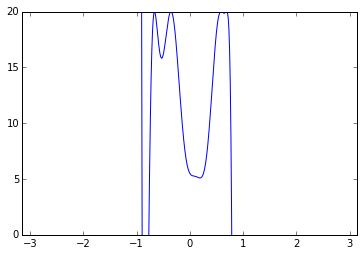

1


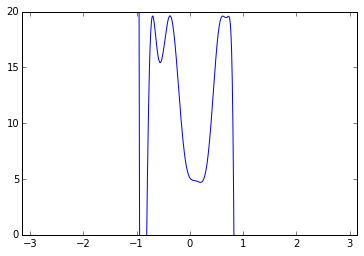

2


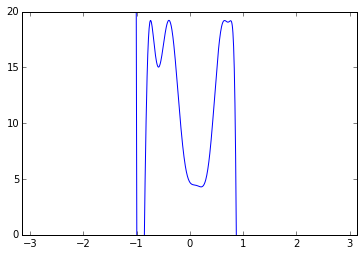

3


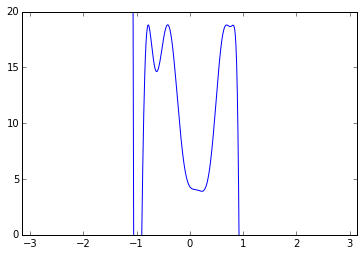

4


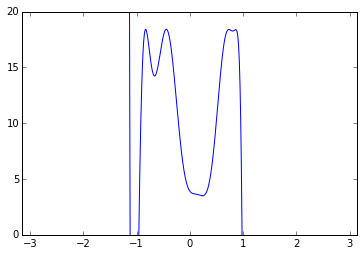

5


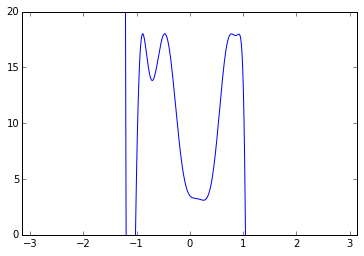

6


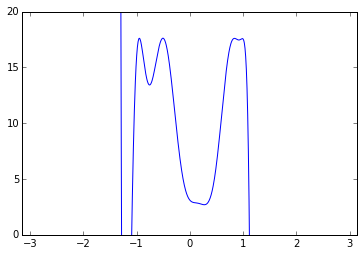

7


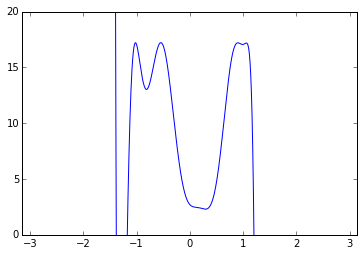

8


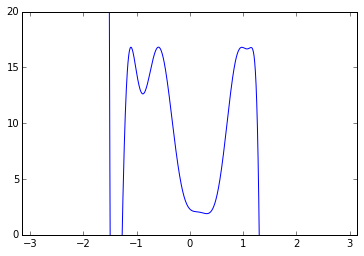

9


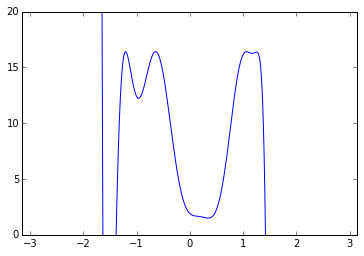

10


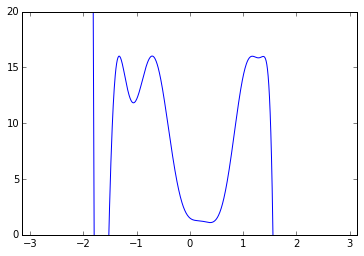

11


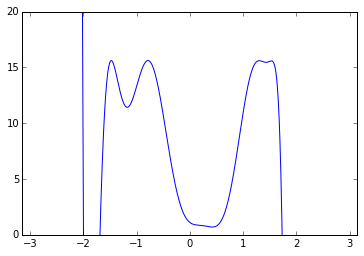

12


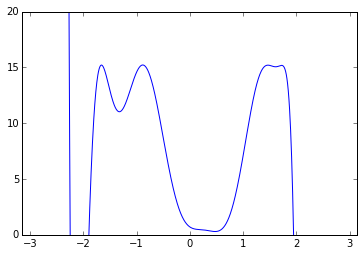

13


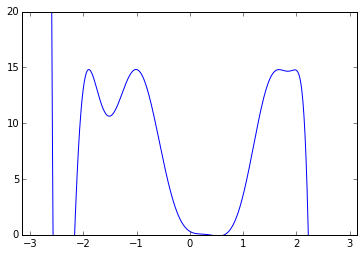

14


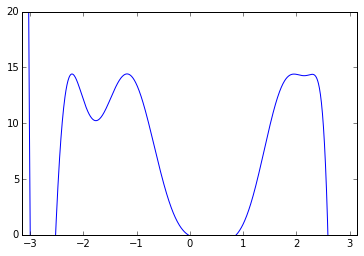

15


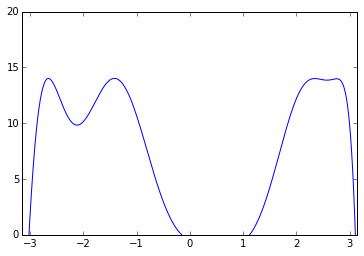

16


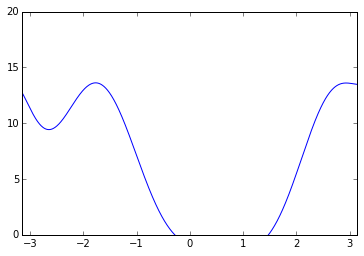

17


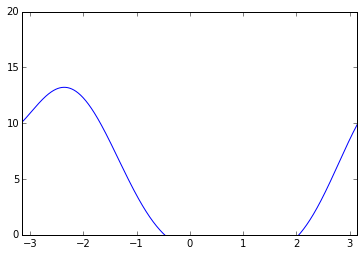

18


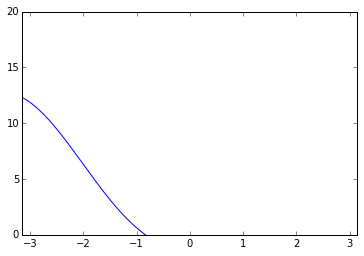

19


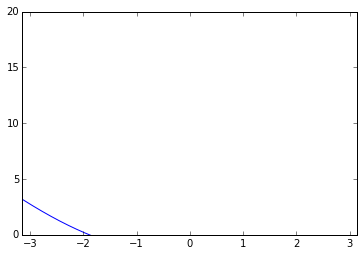

20


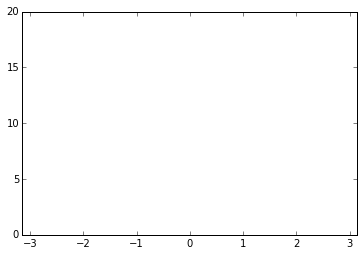

21


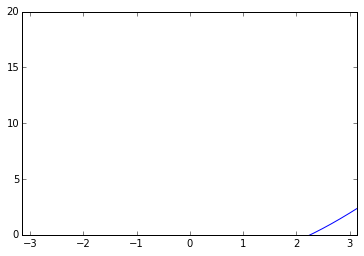

22


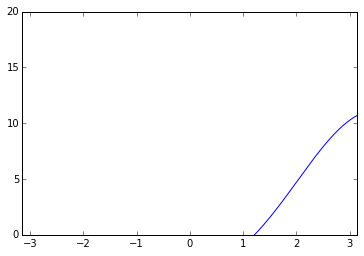

23


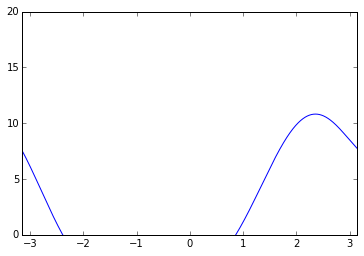

24


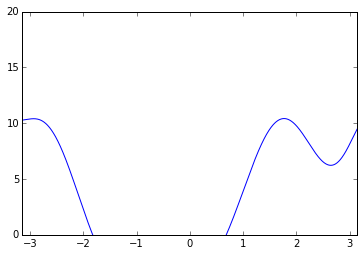

25


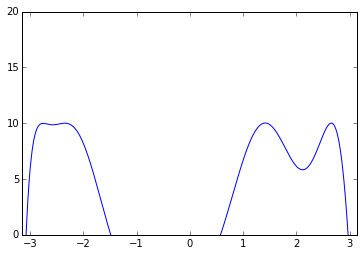

26


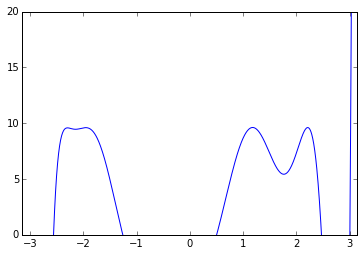

27


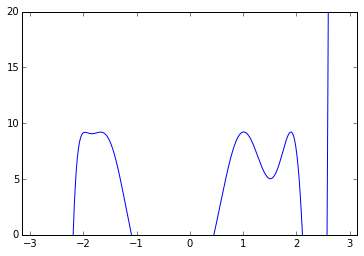

28


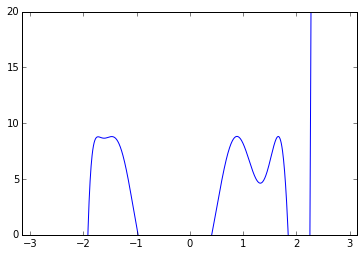

29


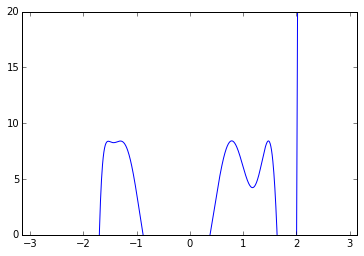

30


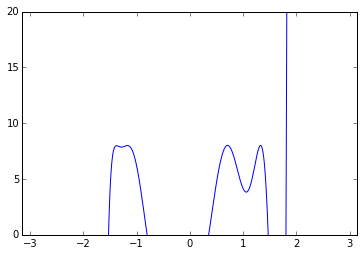

31


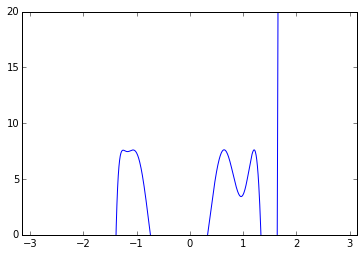

32


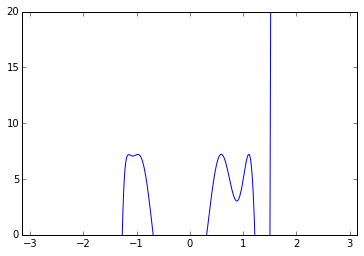

33


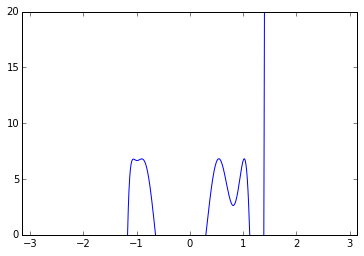

34


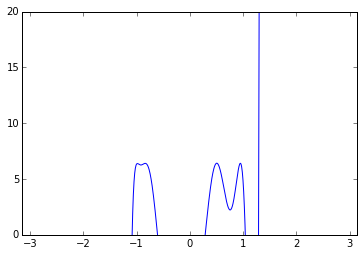

35


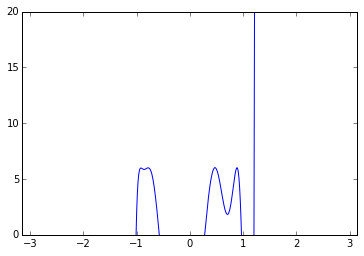

36


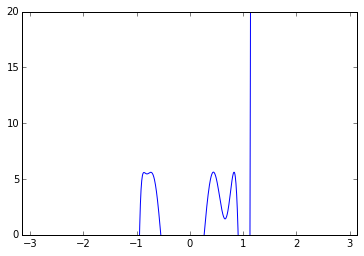

37


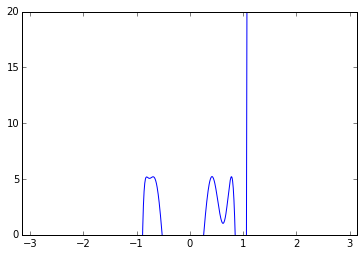

38


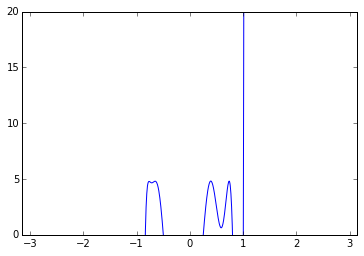

39


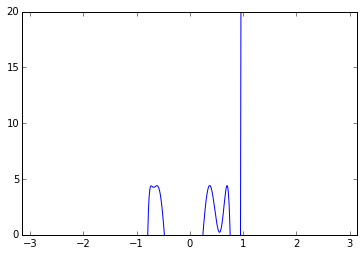

40


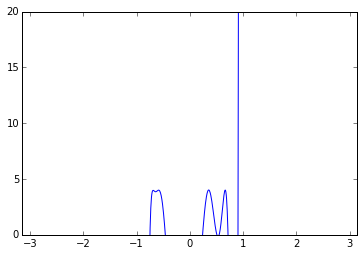

41


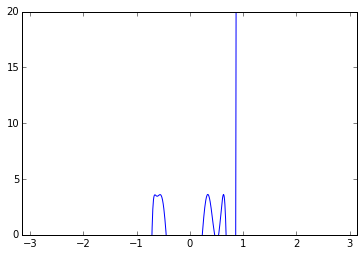

42


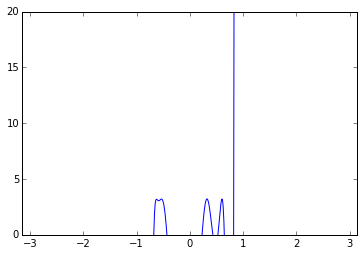

43


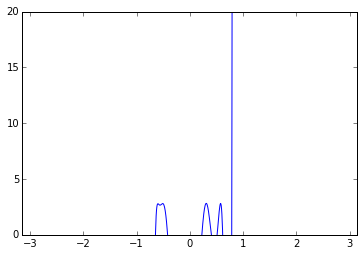

44


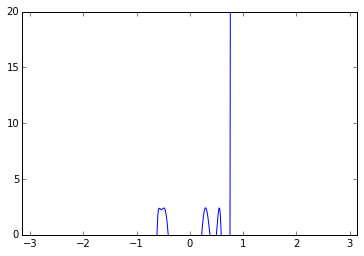

45


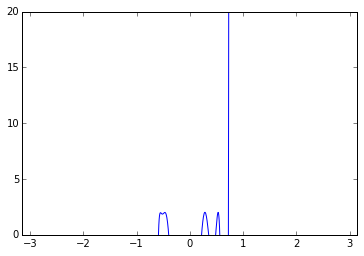

46


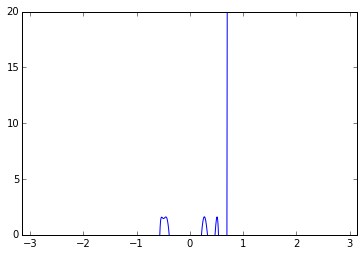

47


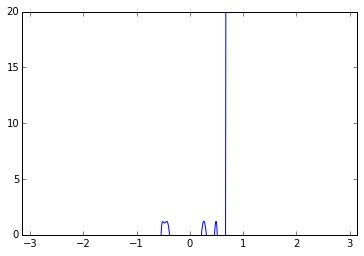

48


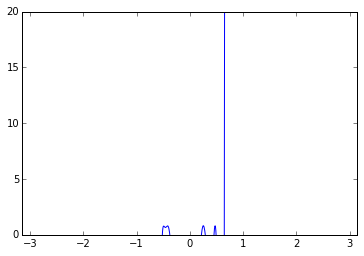

49


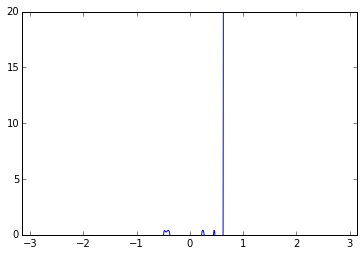

50


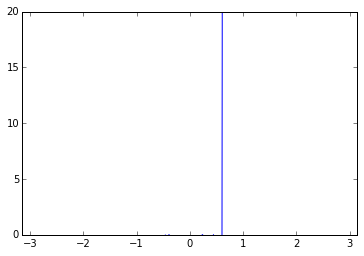

51


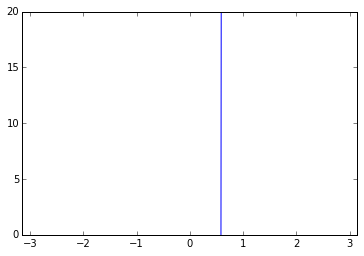

52


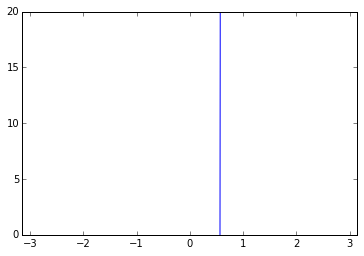

53


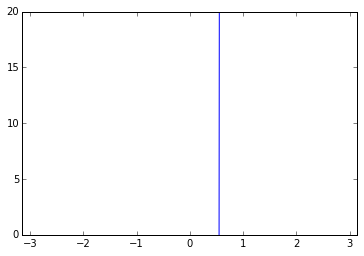

54


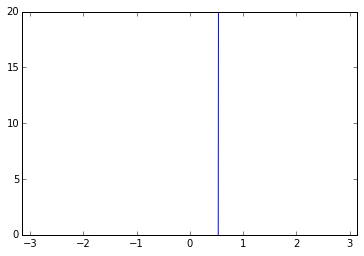

55


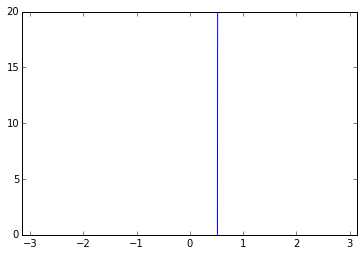

56


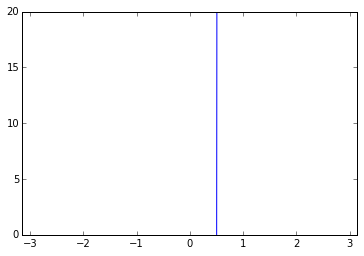

57


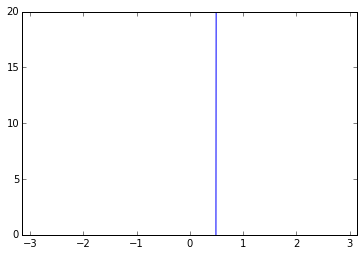

58


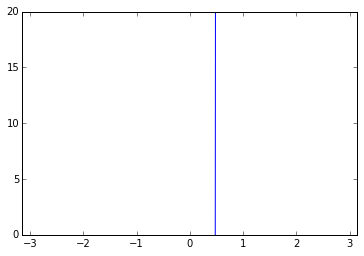

59


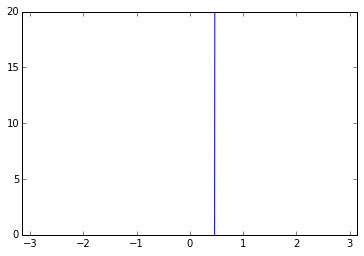

60


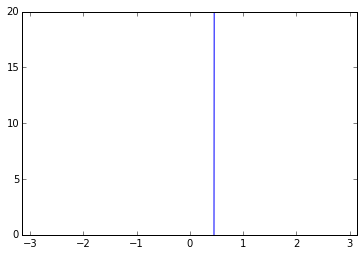

61


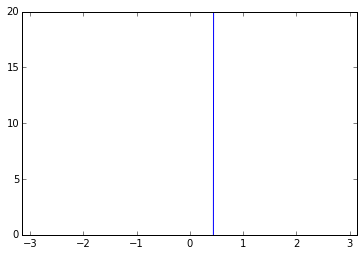

62


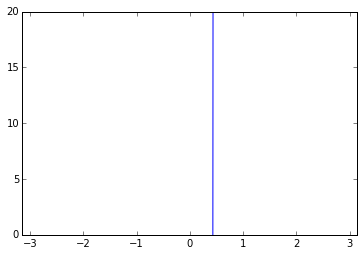

63


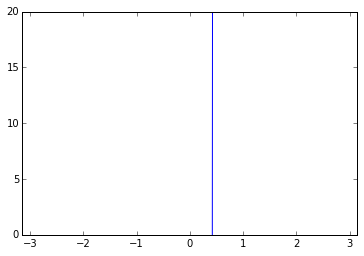

64


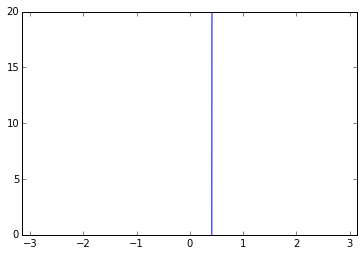

65


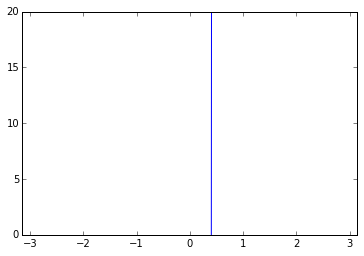

66


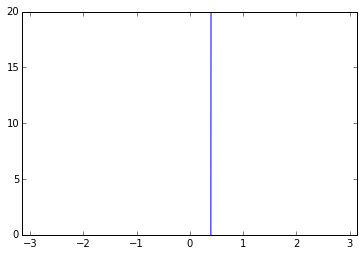

67


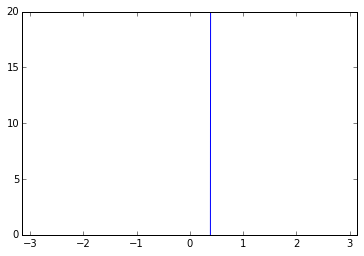

68


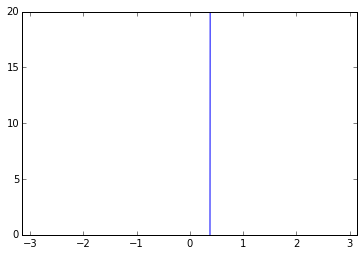

69


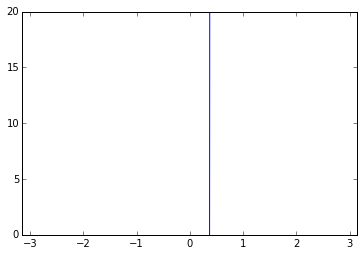

70


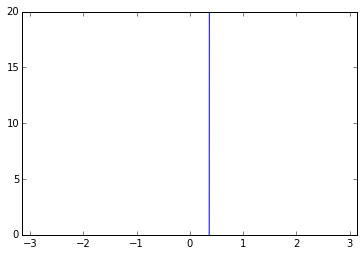

71


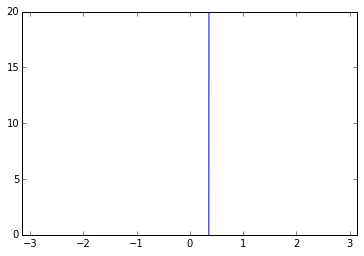

72


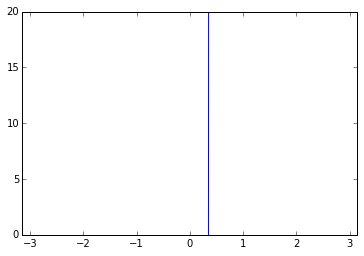

73


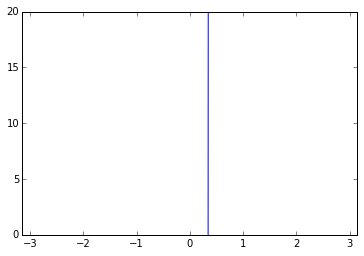

74


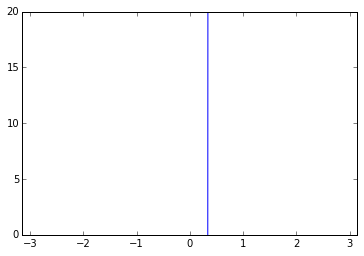

75


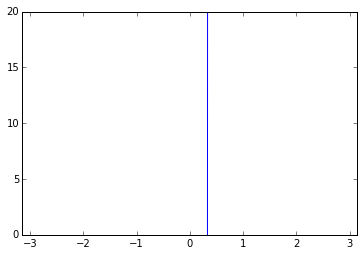

76


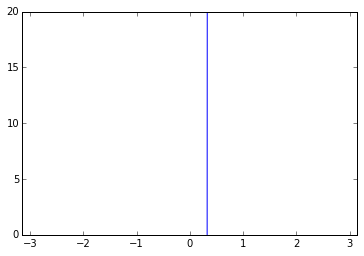

77


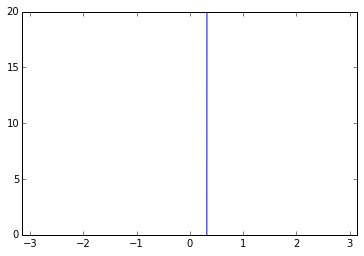

78


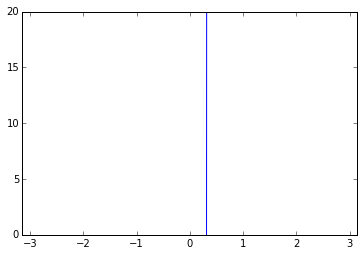

79


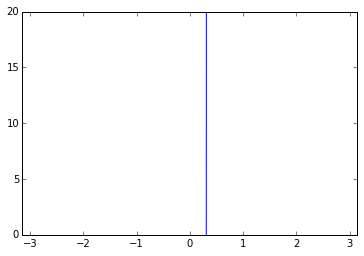

In [8]:
# def hornerMovingMean(x, weights, mean):
#     coefficients = weights[::-1]
#     result = 0
#     for i in coefficients:
#         result = result * (x-mean) + i
#     return result

# def plotHornerMovingMean(weights, mean):
#     x = np.linspace(-math.pi,math.pi,1000)
#     y = x * 0.0
#     for index,val in enumerate(y):
#         y[index] = hornerMovingMean(x[index], weights, mean)
#     plt.plot(x,y)
#     plt.axis([-3.14, 3.14, 0, 20])
#     plt.show()

# for i in range(len(t)):
#     print i
#     plotHornerMovingMean(pixelY[i][:-1],pixelY[i][-1])
    
    
def hornerMovingMeanExpanding(x, weights, mean, beta):
    coefficients = weights[::-1]
    result = 0
    for i in coefficients:
        result = result * beta*(x-mean) + i
    return result

def plotHornerMovingMeanExpanding(weights, mean, beta):
    x = np.linspace(-math.pi,math.pi,1000)
    y = x * 0.0
    for index,val in enumerate(y):
        y[index] = hornerMovingMeanExpanding(x[index], weights, mean, beta)
    plt.plot(x,y)
    plt.axis([-3.14, 3.14, 0, 20])
    plt.show()

for i in range(len(t)):
    print i
    plotHornerMovingMeanExpanding(pixelY[i][:-1],pixelY[i][-2],pixelY[i][-1])

In [9]:
import os
os.system("rm bot.mp4")
%matplotlib qt
plt.rcParams['figure.figsize'] = 20, 15
fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-50, 50), ylim=(-20, 50))
ax.grid()

im = plt.imread('quaddrawing.png')
newax = fig.add_axes([0.497, 0.31, 0.03, 0.1], anchor='SW')
newax.imshow(im)
newax.axis('off')
ax.set_aspect('equal', 'datalim')
     
S_max, = ax.plot([], [], '--' , lw=1, color='red')   
obstacles, = ax.plot([], [], 'o', markersize=20, lw=2, color='gray')
time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

for index in range(D):
    lobj = ax.plot([],[],'-',lw=0.5,color='red')[0]
    laserLines.append(lobj)
    approxobj = ax.plot([],[],'-',lw=0.5,color='green')[0]
    approxLines.append(approxobj)

def init():
    S_max.set_data([], [])
    obstacles.set_data([], [])
    time_text.set_text('')
    
    for line in laserLines:
        line.set_data([],[])
        
    for approxLine in approxLines:
        approxLine.set_data([],[])
    
    return obstacles, time_text, laserLines, approxLines

def animate(i):
    
    # Draw the maximum sensor horizon
    S_max.set_data(S_max_x,S_max_y)
    
    
    # Draw the obstacles as just a bunch of points
    
    all_obs_x = []
    all_obs_y = []
    
    for obs in obsField.ObstaclesList:
        all_obs_x.append(obs.xtraj[i]) #+ obs.plotX) put back in this to plot little points around the circle
        all_obs_y.append(obs.ytraj[i]) #+ obs.plotY)
    
    #all_obs_x = [x_obj1[i], x_obj2[i]]
    #all_obs_y = [y_obj1[i], y_obj2[i]]
    obstacles.set_data(all_obs_x, all_obs_y)
    
    # Draw in the time
    time_text.set_text(time_template%(i*dt))
    
    xlist = []
    ylist = []
    approx_xlist = []
    approx_ylist = []
    
    # Draw the laser intersecting obstacles
    for lasenum, lasevalue in enumerate(laseAngles):

        x_laser_endpoint = x_laser_endpointTraj[i,lasenum]
        y_laser_endpoint = y_laser_endpointTraj[i,lasenum]
        

#         xlist.append([[0,x_laser_endpoint]])
#         ylist.append([[0,y_laser_endpoint]])
        # currently turned off drawing
        xlist.append([[0,0]])
        ylist.append([[0,0]])
        
        # Draw the approximation
        lasevalue2 = transformStandardPolarTheta_to_PlaneTheta(lasevalue)
        Ymean = pixelY[i][-2]
        Ybeta = pixelY[i][-1]
        Yweights = pixelY[i][:-2]
        
        approx_distance = hornerMovingMeanExpanding(lasevalue2,Yweights,Ymean,Ybeta)
        # check if negative, just don't plot if it is
        if (approx_distance < 0):
            #print "found one at ", lasevalue2
            approx_distance = 0
        
        
        x_approx_endpoint = approx_distance*math.cos(lasevalue)
        y_approx_endpoint = approx_distance*math.sin(lasevalue)
        
        if (lasevalue2 - Ymean < math.pi/4) and (Ymean - lasevalue2 < math.pi/4):
            approx_xlist.append([[0,x_approx_endpoint]])
            approx_ylist.append([[0,y_approx_endpoint]])
        else:
            approx_xlist.append([[0,0]])
            approx_ylist.append([[0,0]])

    for lnum,line in enumerate(laserLines):
        line.set_data(xlist[lnum], ylist[lnum]) # set data for each line separately. 
        
    for lnum,approxline in enumerate(approxLines):
        approxline.set_data(approx_xlist[lnum], approx_ylist[lnum]) # set data for each line separately. 

    return obstacles, time_text, laserLines, approxLines

ani = animation.FuncAnimation(fig, animate, np.arange(1, len(y)),
    interval=20, blit=False, init_func=init)
ani.save('bot.mp4', fps=20, bitrate=5000, codec="h264", writer=writer)
plt.show()

In [10]:
# import os
# os.system("rm bot_h264.mp4")
# os.system("avconv -i bot.mp4 -c:v h264 -c:a copy bot_h264.mp4")

In [11]:
# import os
# import io
# import base64
# from IPython.display import HTML

# video = io.open('/Users/pflomacpro/GeometricPDEs/_Plane/bot_h264.mp4', 'r+b').read()
# encoded = base64.b64encode(video)
# HTML(data='''<video alt="test" controls>
#                 <source src="data:video/mp4;base64,{0}" type="video/mp4" />
#              </video>'''.format(encoded.decode('ascii')))